<a href="https://colab.research.google.com/github/AadeshVarude/Zhangs-method-camera-calibration/blob/main/Camera_caliberation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detecting the corners of the checker board.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2 as cv
import scipy
import matplotlib.pyplot as plt
import math
import os
import scipy.optimize
from copy import deepcopy
from google.colab.patches import cv2_imshow
import glob


Need to make the 3rd column of the matrix for world and corner points as 1


In [ ]:
chessboardSize = (6,9)
# frameSize = (1440,1080)
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

size_of_chessboard_squares_mm = 12.5
objp = objp * size_of_chessboard_squares_mm

# objp[:,:2]=1
# Arrays to store object points and image points from all the images.
worldpoints_3D = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

path='/content/drive/MyDrive/Calibration_Imgs/*.*'
images = glob.glob(path)

for image in images:
  img = cv.imread(image)
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  # Find the chess board corners
  ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)

  # If found, add object points, image points (after refining them)
  if ret == True:

      worldpoints_3D.append(objp)
      corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
      corners2=corners2.reshape(-1,2)
      imgpoints.append(corners2)

      # Draw and display the corners
      cv.drawChessboardCorners(img, chessboardSize, corners2, ret)
      # cv2_imshow(img)

In [ ]:
def getH(set1, set2):
  nrows = set1.shape[0]
  if (nrows < 4):
    print("Need atleast four points to compute SVD.")
    return 0

  x = set1[:, 0]
  y = set1[:, 1]
  xp = set2[:, 0]
  yp = set2[:,1]
  A = []
  for i in range(nrows):
    row1 = np.array([x[i], y[i], 1, 0, 0, 0, -x[i]*xp[i], -y[i]*xp[i], -xp[i]])
    A.append(row1)
    row2 = np.array([0, 0, 0, x[i], y[i], 1, -x[i]*yp[i], -y[i]*yp[i], -yp[i]])
    A.append(row2)

  A = np.array(A)
  U, E, V = np.linalg.svd(A, full_matrices=True)
  H = V[-1, :].reshape((3, 3))
  H = H / H[2,2]
  return H

In [ ]:
def cal_H(worldpoints_3D,imgpoints):
  Hset=[]
  for i in range(len(imgpoints)):
    H1,_=cv.findHomography(worldpoints_3D[i],imgpoints[i],cv.RANSAC,5.0)
    H=getH(worldpoints_3D[i], imgpoints[i])
    Hset.append(H)
  return Hset

**Getting the Homography**

In [ ]:
Hset=cal_H(worldpoints_3D,imgpoints)
Hset=np.array(Hset)
len(Hset)


13

In [ ]:
def get_vij(h1,h2):
  vij=np.array([h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[1],h1[1]*h2[1], h1[2]*h2[0]+h1[0]*h2[2], h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]])
  return vij.T

In [ ]:
def get_V(Hset):
  v=[]
  for h in Hset:
    h1=h[:,0]
    h2=h[:,1]

    v12=get_vij(h1,h2)
    v11=get_vij(h1,h1)
    v22=get_vij(h2,h2)
    v.append(v12.T)
    v.append((v11-v22).T)
  return np.array(v)

In [ ]:
def get_B(Hset):
  v=get_V(Hset)
  # print(len(v))
  U,sig,V=np.linalg.svd(v)
  b=V[-1,:]
  B = np.zeros((3,3))
  B[0,0] = b[0]
  B[0,1] = b[1]
  B[0,2] = b[3]
  B[1,0] = b[1]
  B[1,1] = b[2]
  B[1,2] = b[4]
  B[2,0] = b[3]
  B[2,1] = b[4]
  B[2,2] = b[5]
  return B

In [ ]:
B=get_B(Hset)
B

26


array([[ 1.50164833e-07,  2.57696406e-10, -1.14426342e-04],
       [ 2.57696406e-10,  1.51755630e-07, -2.07283663e-04],
       [-1.14426342e-04, -2.07283663e-04,  9.99999972e-01]])

**Getting the A matrix**

In [ ]:
def get_A(B):
  v0 = (B[0,1] * B[0,2] - B[0,0] * B[1,2])/(B[0,0] * B[1,1] - B[0,1]**2)
  lamb = B[2,2] - (B[0,2]**2 + v0 * (B[0,1] * B[0,2] - B[0,0] * B[1,2]))/B[0,0]
  alpha = np.sqrt(lamb/B[0,0])
  beta = np.sqrt(lamb * (B[0,0]/(B[0,0] * B[1,1] - B[0,1]**2)))
  gamma = -(B[0,1] * alpha**2 * beta) / lamb
  u0 = (gamma * v0 / beta) - (B[0,2] * alpha**2 / lamb)
  A = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
  return A

In [ ]:
A=get_A(B)

In [ ]:
def getRotationAndTrans(A, Hset): # Function for obtaining the Rotation and Translation matrix
  RT = []
  i=0
  for H in Hset:
    # print(i)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]
    lamb = np.linalg.norm(np.dot(np.linalg.inv(A), h1), 2)

    r1 = np.dot(np.linalg.inv(A), h1) / lamb
    r2 = np.dot(np.linalg.inv(A), h2) / lamb
    r3 = np.cross(r1, r2)
    t = np.dot(np.linalg.inv(A), h3) / lamb
    rt = np.vstack((r1, r2, r3, t)).T
    RT.append(rt)
    i+=1
  return RT

In [ ]:
RT=getRotationAndTrans(A,Hset)
len(RT)

13

In [ ]:
kc=np.array([0,0]).reshape(2,1)
kc

array([[0],
       [0]])

Now we have all the parametres K, R, t, k now we minimize the grometric error ∑i=1N∑j=1M||xi,j−x^i,j(K,Ri,ti,Xj,k)||

In [ ]:
def get_params(A,kc):
  alpha = A[0,0]
  gamma = A[0,1]
  beta = A[1,1]
  u0 = A[0,2]
  v0 = A[1,2]
  k1 = kc[0]
  k2 = kc[1]

  x0 = np.array([alpha, gamma, beta, u0, v0, k1, k2])
  return x0


In [ ]:
x0=get_params(A,kc)
x0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


array([2048.6100689984987, -3.497129961817238, 2037.847347958932,
       759.6631182525464, 1364.6142811325922, array([0]), array([0])],
      dtype=object)

In [ ]:
def retrieveA(x0):
  alpha, gamma, beta, u0, v0, k1, k2 = x0
  A = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]]).reshape(3,3)
  kc = np.array([k1, k2]).reshape(2,1)
  return A, kc

In [ ]:
a=len(worldpoints_3D)
print(a)
print(len(worldpoints_3D[0]))
# for i in range(a):
points=worldpoints_3D[0][12]
points[0]



13
54


0.0

In [ ]:
a=RT[0]
a[:,0]

array([-0.99938926, -0.03488194, -0.00208827])

In [ ]:
def loss_func(x0,RT, imgpoints, worldpoints_3D):
  A,kc=retrieveA(x0)
  error=[]
  alpha, gamma, beta, u0, v0, k1, k2 =x0
  for i, image_corners in enumerate(imgpoints):
    rt=RT[i]
    rt3D = np.array([rt[:,0], rt[:,1], rt[:,3]]).reshape(3,3)
    rt3D=rt3D.T
    art3=np.dot(A,rt3D)
    te=0

    for j in range(len(worldpoints_3D[0])):
      wp=worldpoints_3D[0][j]
      wp2d=np.array([wp[0],wp[1],1]).reshape(3,1)
      wp3d=np.array([wp[0],wp[1],wp[2],1]).reshape(4,1)

      #radial distortion
      XYZ=np.dot(rt,wp3d)
      x=XYZ[0]/XYZ[2]
      y=XYZ[1]/XYZ[2]
      r=np.sqrt(x**2+y**2)
      mij=image_corners[j]
      mij=np.array([mij[0],mij[1],1],dtype='float').reshape(3,1)
      uvw=np.dot(art3,wp2d)
      u=uvw[0]/uvw[2]
      v=uvw[1]/uvw[2]
      u_dash = u + (u - u0) * (k1 * r**2 + k2 * r**4)
      v_dash = v + (v - v0) * (k1 * r**2 + k2 * r**4)
      mij_dash = np.array([u_dash, v_dash, 1], dtype = 'float').reshape(3,1)
      e = np.linalg.norm((mij - mij_dash), ord=2)
      te+=e
    error.append(te/54)
  return np.array(error)





In [ ]:
x0 = get_params(A, kc)
res = scipy.optimize.least_squares(fun=loss_func, x0=x0, method="lm", args=[RT, imgpoints, worldpoints_3D])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


In [ ]:
def reproj(A,K,RT ,imgpoints, worldpoints_3D):
  error=[]
  points=[]
  alpha, gamma, beta, u0, v0, k1, k2 =get_params(A,K)
  for i, image_corners in enumerate(imgpoints):
    rt=RT[i]
    rt3D = np.array([rt[:,0], rt[:,1], rt[:,3]]).reshape(3,3)
    rt3D=rt3D.T
    art3=np.dot(A,rt3D)
    te=0
    rp=[]

    for j in range(len(worldpoints_3D[0])):
      wp=worldpoints_3D[0][j]
      wp2d=np.array([wp[0],wp[1],1]).reshape(3,1)
      wp3d=np.array([wp[0],wp[1],wp[2],1]).reshape(4,1)

      #radial distortion
      XYZ=np.dot(rt,wp3d)
      x=XYZ[0]/XYZ[2]
      y=XYZ[1]/XYZ[2]
      r=np.sqrt(x**2+y**2)
      mij=image_corners[j]
      mij=np.array([mij[0],mij[1],1],dtype='float').reshape(3,1)
      uvw=np.dot(art3,wp2d)
      u=uvw[0]/uvw[2]
      v=uvw[1]/uvw[2]
      u_dash = u + (u - u0) * (k1 * r**2 + k2 * r**4)
      v_dash = v + (v - v0) * (k1 * r**2 + k2 * r**4)
      rp.append([u_dash,v_dash])

      mij_dash = np.array([u_dash, v_dash, 1], dtype = 'float').reshape(3,1)
      e = np.linalg.norm((mij - mij_dash), ord=2)
      te+=e

    error.append(te/54)
    points.append(rp)
  error=np.array(error)
  err_avg=np.sum(error)/(13*54)
  return err_avg,points


**Geting the A and K matrix for undistorting the images**

In [ ]:
A_new,K_new=retrieveA(res.x)
RT_n=getRotationAndTrans(A_new,Hset)
error,points=reproj(A_new,K_new,RT_n,imgpoints, worldpoints_3D)
K = np.array(A_new, np.float32).reshape(3,3)
D = np.array([K_new[0],K_new[1], 0, 0] , np.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=i

In [ ]:
fimages=[]
for i,image_points in enumerate(points):
  img = cv.imread(images[i])
  image = cv.undistort(img, K, D)
  for point in image_points:
    x = int(point[0])
    y = int(point[1])
    image = cv.circle(image, (x, y), 5, (0, 0, 255), 3)
  fimages.append(image)


**Final Results**

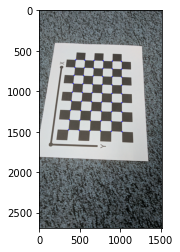

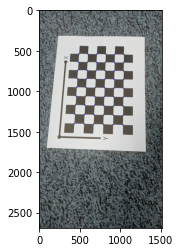

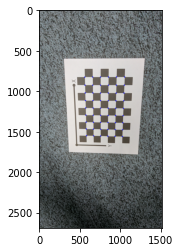

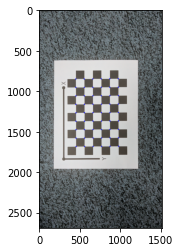

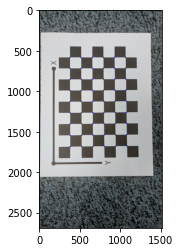

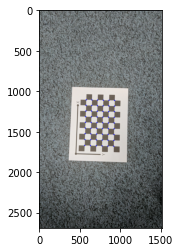

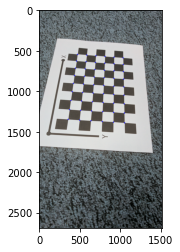

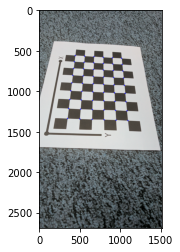

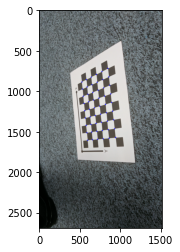

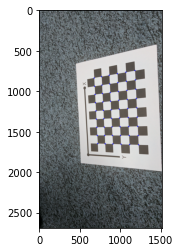

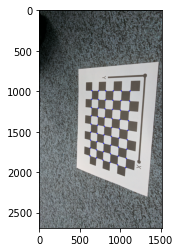

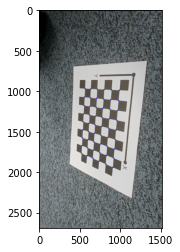

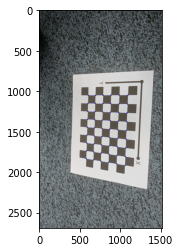

In [ ]:
for image in fimages:
  plt.imshow(image)
  plt.show()